# Data Wrangling
For my capstone project, I want to build a convolutional autoencoder that trains on color images and colorizes grayscale images using the decoder. I have taken screenshots from YouTube videos and stored them as numpy arrays in *LAB* colorspace. I skipped over the beginning and ending of the videos as they are from a TV show and I didn't want to include the credits. In this notebook, we will check the data and do some cleanning if necessary. 

In [1]:
# Import libraries
import tables
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

All the image data is stored in a HDF5 file with two tables: `Train` and `Test`. The `Train` table contains over 17,000 images with three channels or coordinates (lightness, green-red, and blue-yellow) while the `Test` table contains a small set of grayscale screenshots (with one channel, lightness). We will load a small subset of the trainning data. 

In [2]:
def load_training_data(start_idx=None, end_idx=None):
    mdb = tables.open_file('youtube_data.h5')
    tbl = mdb.root.Train
    if (start_idx is None) and (end_idx is None):
        L = tbl.cols.L[:]
        A = tbl.cols.A[:]
        B = tbl.cols.B[:]
    else:
        assert (start_idx is not None) and (end_idx is not None), 'Please provide both start and end indices.'
        L = tbl.cols.L[start_idx:end_idx]
        A = tbl.cols.A[start_idx:end_idx]
        B = tbl.cols.B[start_idx:end_idx]
    mdb.close()
    
    img_size = (360, 480)
    n = int(L.shape[0]/np.prod(img_size))
    L = L.reshape(n, img_size[0], img_size[1])
    A = A.reshape(n, img_size[0], img_size[1])
    B = B.reshape(n, img_size[0], img_size[1])
    
    data = np.stack((L, A, B), axis=3)
    return data

## Sanity Checks

In [3]:
train_data = load_training_data(0, 20*360*480) #(360,480) is the image dimension, here we load 20 images
train_data.shape

(20, 360, 480, 3)

We've loaded 20 images from file, each image is $360\times480$ pixels with three channels. Let's check the values in array.

In [4]:
# Check if there's any NaN's
np.sum(np.isnan(train_data))

0

There's no missing value in data. Next we will check the range to make sure they are in line with what we are expecting.

In [5]:
train_data.dtype

dtype('uint8')

In [6]:
np.max(train_data)

255

In [7]:
np.min(train_data)

0

In [8]:
np.max(train_data, axis=(0,1,2)) # Max value of each channel

array([255, 181, 160], dtype=uint8)

The images are captured and converted to *LAB* color space using the [cv2](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_setup/py_intro/py_intro.html#intro) library. Diverging from the standard range of $L \in [0,100]$ and $a,b \in [-128, 127]$, `cv2` scaled all channels so that they are between 0 and 255 (see [here](https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html)). The data from the small subset falls within the range.

## Cleaning

There might be momentary black screens between sceens that we don't want to include in the train data. We will check the lightness and remove those images if necessary.

In [9]:
black_screen = load_training_data(9500*360*480, 9501*360*480)
np.nansum(black_screen[0,:,:,0])

16

In [10]:
np.unique(black_screen[0,:,:,1:2])

array([128], dtype=uint8)

For 172,800 pixels, the total value of lightness is only 16! Moreover, the other two channles only have one unique value 128, which is 0 in the standard *LAB* convention (so neither green nor red in the `a` channel, neither blue nor yellow in the `b` channel). We shall remove images like this before feeding into the model.

## Visualization

Let's see what one of the images looks like. We will convert it back to RGB for visualization.

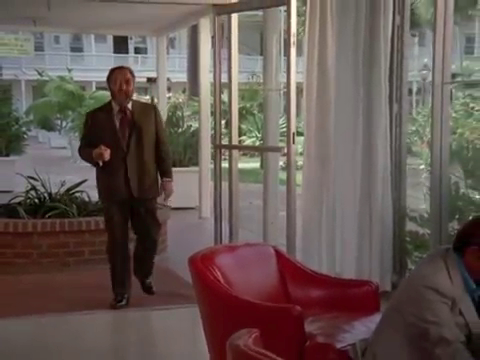

In [11]:
lab_data = train_data[0]
rgb_data = cv2.cvtColor(lab_data, cv2.COLOR_LAB2RGB)
img = Image.fromarray(rgb_data)
display(img)

We can visualize the different layers as well.

In [12]:
def channel_lab2rgb(image, channel):
    assert channel in ('a', 'b')
    channel_map = {'a':1, 'b':2} # Map channel name to dimension
    out = np.zeros((image.shape)).astype('uint8')
    # Set lightness so that we can actually see the colors
    out[:,:,0] = 204
    c = channel_map[channel]
    out[:,:,c] = image[:,:,c]
    return cv2.cvtColor(out, cv2.COLOR_LAB2RGB)

def extract_rgb_channel(image, channel):
    assert channel in ('r', 'g', 'b')
    channel_map = {'r':0, 'g':1, 'b':2} # Map channel name to dimension
    out = np.zeros((image.shape)).astype('uint8')
    c = channel_map[channel]
    out[:,:,c] = image[:,:,c]
    return out

def plot_layers(lab_data):
    rgb_data = cv2.cvtColor(lab_data, cv2.COLOR_LAB2RGB)
    
    fig = plt.figure(figsize=(13,6))

    # LAB layers
    ax = fig.add_subplot(2,3,1)
    ax.imshow(lab_data[:,:,0], cmap='gray')
    ax.set_title("L: lightness")

    ax = fig.add_subplot(2,3,2)
    img = channel_lab2rgb(lab_data, 'a') 
    ax.imshow(img)
    ax.set_title("A: green-red specturm")

    ax = fig.add_subplot(2,3,3)
    img = channel_lab2rgb(lab_data, 'b') 
    ax.imshow(img)
    ax.set_title("B: blue-yellow specturm")

    # RGB layers
    ax = fig.add_subplot(2,3,4)
    img = extract_rgb_channel(rgb_data, 'r')
    ax.imshow(img)
    ax.set_title("R: red")

    ax = fig.add_subplot(2,3,5)
    img = extract_rgb_channel(rgb_data, 'g')
    ax.imshow(img)
    ax.set_title("G: green")

    ax = fig.add_subplot(2,3,6)
    img = extract_rgb_channel(rgb_data, 'b')
    ax.imshow(img)
    ax.set_title("B: blue")
    plt.subplots_adjust(hspace=0.4)
    plt.show()    

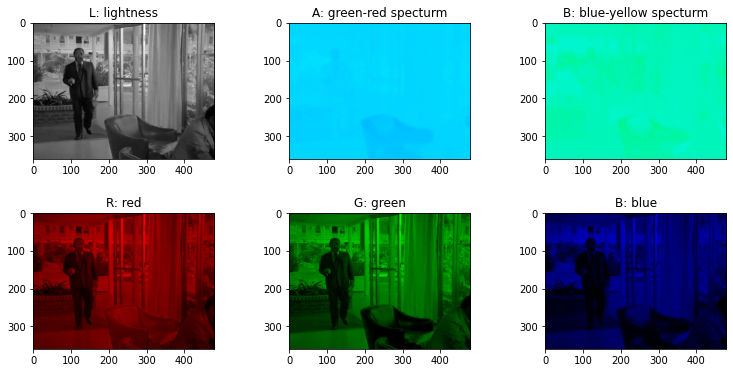

In [13]:
plot_layers(lab_data)

Load another one just for the fun of it.

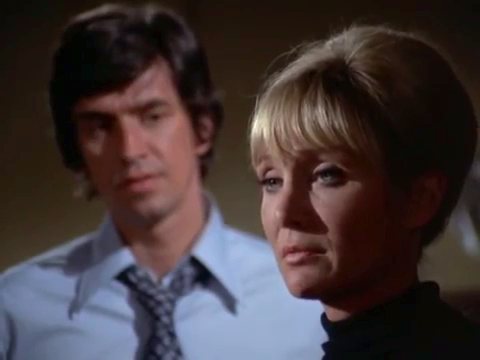

In [14]:
train_data = load_training_data(7500*360*480, 7501*360*480)
lab_data = train_data[0]
rgb_data = cv2.cvtColor(lab_data, cv2.COLOR_LAB2RGB)
img = Image.fromarray(rgb_data)
display(img)

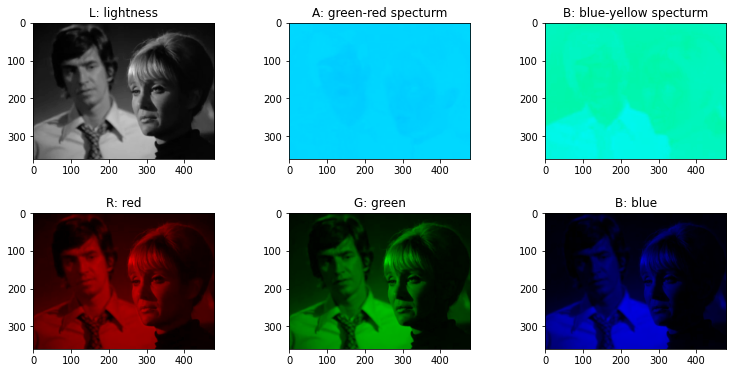

In [15]:
plot_layers(lab_data)

## Preprocessing
The image data is stored as 8 bit unsigned integers for efficiency but they would need to be converted to float and re-scaled to be between 0 and 1 for computation.